In [11]:
# Import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

# Random seed for reproducibility
seed = 202
np.random.seed(seed)

In [12]:
# Import the train set and test set
train_data = pd.read_csv("final_train.csv", delimiter=",")
test_data = pd.read_csv("final_test.csv", delimiter=",")

In [13]:
#train_data = train_data.drop('DataArpu', axis=1)
train_data = train_data.drop('ID', axis=1)
# Sort the dataset
train_data = train_data.iloc[np.random.permutation(len(train_data))]
train_data = train_data.reset_index(drop=True)

In [14]:
array = np.asarray(train_data)

# X,Y are the splits between features and labels used to evaluate SelectKBest
X = array[:,0:train_data.shape[1]-1]
X = np.asarray(X)
Y = array[:,train_data.shape[1]-1]
Y = np.asarray(Y)

In [24]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bin_chi2_test = SelectKBest(score_func=chi2, k=32)
fit = bin_chi2_test.fit(X,Y)

v_chi2_test = SelectKBest(score_func=chi2, k=14)
fit = v_chi2_test.fit(X,Y)

In [25]:
bin_feat = train_data.columns[bin_chi2_test.get_support(indices=True)]
v_feat = train_data.columns[v_chi2_test.get_support(indices=True)]

In [26]:
def features_labels_split(data):
    
    features = data[bin_feat]
    labels = data['Product']
    return features, labels

In [27]:
def train_test_validation_split(features, labels, val_samples, test_samples):

    features = np.asarray(features)
    labels =np.asarray(labels)
    
    X_test = features[0:test_samples]
    y_test = labels[0:test_samples]

    X_val = features[test_samples:test_samples + val_samples]
    y_val = labels[test_samples:test_samples + val_samples]

    X_train = features[test_samples + val_samples:]
    y_train = labels[test_samples + val_samples:]

    return X_train, X_test, X_val, y_train, y_test, y_val

## first data creation

In [28]:
# train_feat, train_label are the splits of train_data between features and labels
train_feat, train_label = features_labels_split(train_data)

# bin_train_label is the same of train_label but BINARY
bin_train_label = []
 
for i in range(0, len(train_label)):
    if(train_label[i] == 0):
        bin_train_label.append(0)
    else:
        bin_train_label.append(1)
bin_train_label = np.asarray(bin_train_label)
#print(train_label)
#print(bin_train_label)
num_val_samples = 0
num_test_samples = 950

# bin_X_train, bin_X_test, bin_X_val, bin_y_train, bin_y_test, bin_y_val are the splits of train_feat and bin_train_label
bin_X_train, bin_X_test, bin_X_val, bin_y_train, bin_y_test, bin_y_val = train_test_validation_split(train_feat, bin_train_label, num_val_samples, num_test_samples)

## compute the best features for the first model

Model: XGB, Avg_Score: 0.695, Num_Feat: 32


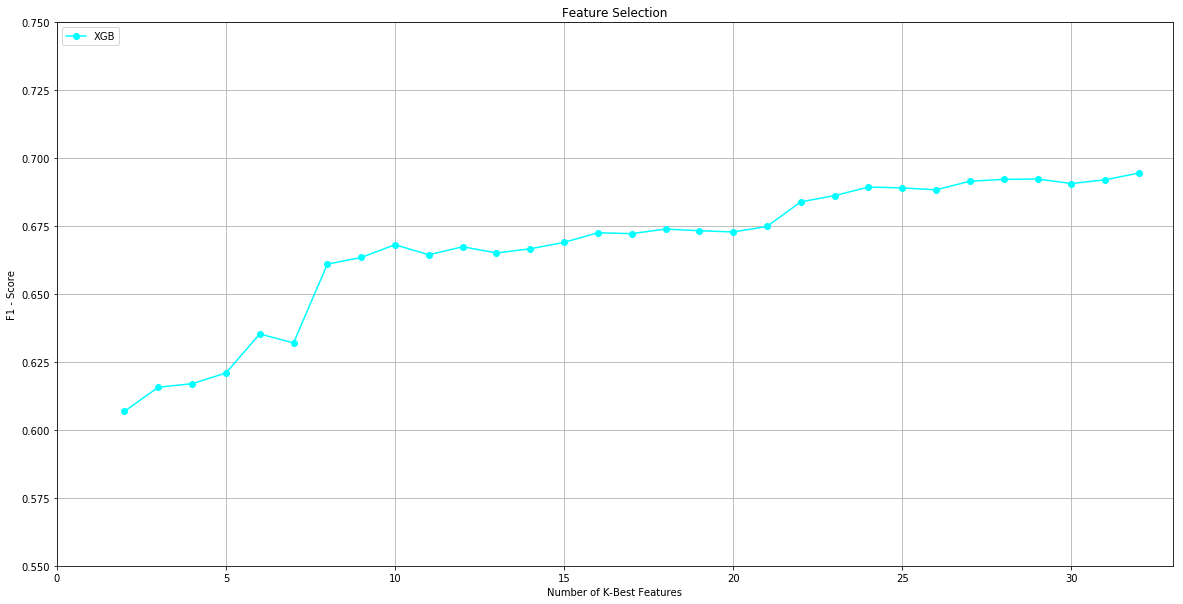

In [23]:
models = []
models.append(('XGB', bin_xgb, 'Cyan'))


feat_range = bin_X_train.shape[1]

n = ['XGB']
n_number = np.arange(2,feat_range,1)
# Transforming the lists into array for plotting
plt.figure(figsize=(20, 10))
plt.title('Feature Selection')
plt.xlabel("Number of K-Best Features")
plt.ylabel("F1 - Score")
plt.grid()

num_feat_arr = []
for name, model, c in models:
    
    scores = [0, 0]
    results = []

    for n in range(2,feat_range):

        selection = SelectKBest(k=n).fit(bin_X_train,bin_y_train)
        X_k = selection.transform(bin_X_train)
        
        
        # Feature Scaling
        from sklearn.preprocessing import StandardScaler
        sc = StandardScaler()
        X_k = sc.fit_transform(X_k)
        
        score = cross_val_score(estimator = model, X = X_k, y = bin_y_train, cv = 10, scoring='f1')
        f1 = score.mean()
        
        results.append(f1)
        
        std = score.std()
        if scores[0] < f1:
            scores = [f1, n]
  
    plt.plot(n_number, results, 'o-', color=c, label=name)
    
    num_feat_arr.append(scores[1])
    max_avg = np.average(scores)
    
    print("Model: %s, Avg_Score: %.3f, Num_Feat: %d" % (name, scores[0], scores[1]))  


plt.axis([0, feat_range , 0.55, 0.75])
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
plt.show()

## first model tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

classifier = XGBClassifier(
                           max_depth=5, min_child_weight=2,
                           colsample_bytree=0.75, subsample=0.85,
                           reg_alpha=0.8, reg_lambda=0.9,
                           n_jobs=-1, objective='binary:logistic', random_state=seed)

# 0.6957
learning_rate = np.arange(0.001,0.01,0.002)#0.05
n_estimators = np.arange(1000,2000,100)#450

max_depth = (4,5,6)
min_child_weight = (0,1,2)

gamma = np.arange(0.0,0.3,0.05)

subsample = (0.8,0.85,0.9)
colsample_bytree = (0.7,0.75,0.8)

reg_alpha = (0.75,0.8,0.85)
reg_lambda = (0.9,0.95,1)

parameters = [{
    'learning_rate':learning_rate,
    'n_estimators':n_estimators
               }]

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring='f1',
                           cv = 10,
                           n_jobs = -1)

grid_search = grid_search.fit(bin_X_train, bin_y_train)
best_f1 = grid_search.best_score_
best_parameters = grid_search.best_params_
print(best_f1)
print(best_parameters)
'''
best setup on grid search: 0.696
learning_rate=0.05, n_estimators= 450,
                           max_depth=5, min_child_weight=2,
                           colsample_bytree=0.75, subsample=0.85
'''

## first training

XGB: 0.693 (0.021)
baseXGB: 0.681 (0.021)


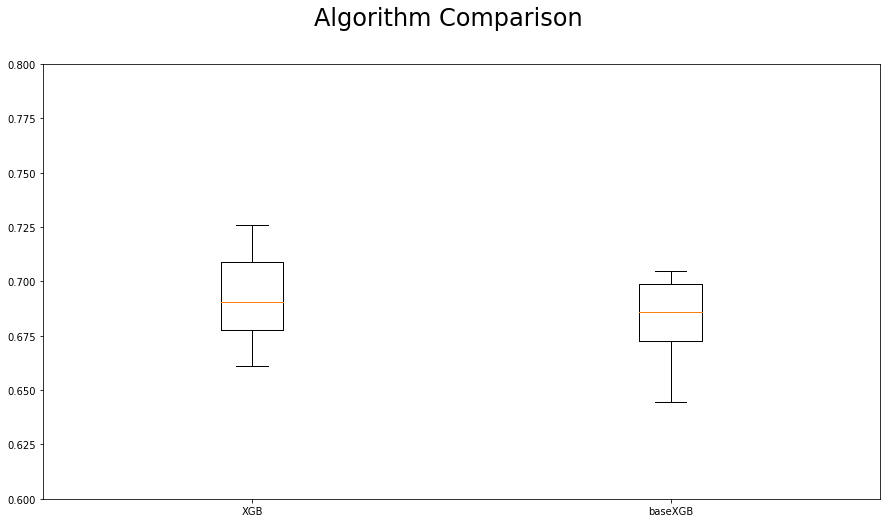

In [29]:
from xgboost import XGBClassifier


bin_xgb = XGBClassifier(learning_rate=0.05, n_estimators= 450,
                           max_depth=5, min_child_weight=2,
                           colsample_bytree=0.75, subsample=0.85,
                           reg_alpha=0.8, reg_lambda=0.9,
                           n_jobs=-1, objective='binary:logistic', random_state=seed)
base_xgb = XGBClassifier(n_jobs=-1, objective='binary:logistic', random_state=seed)

models = []
models.append(('XGB', bin_xgb))
models.append(('baseXGB', base_xgb))




from sklearn.model_selection import cross_val_score

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, bin_X_train, bin_y_train, cv=kfold, scoring='f1', n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Algorithm Comparison', fontsize=24)
ax = fig.add_subplot(1,1,1)
plt.boxplot(results)
plt.ylim([0.60,0.80])
ax.set_xticklabels(names)
plt.show()

In [35]:
# Test Performance

bin_test_model = XGBClassifier(learning_rate=0.05, n_estimators= 450,
                           max_depth=5, min_child_weight=2,
                           colsample_bytree=0.75, subsample=0.85,
                           reg_alpha=0.8, reg_lambda=0.9,
                           n_jobs=-1, objective='binary:logistic', random_state=seed)
bin_test_model.fit(bin_X_train, bin_y_train)
bin_y_pred = bin_test_model.predict(bin_X_test)
# F1
print("F1 score on binary unseen data: %.3f" % f1_score(bin_y_test, bin_y_pred))

F1 score on binary unseen data: 0.700


c:\users\eugen\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## second data creation

In [56]:
# v_train_feat, v_train_label are subsets of train_feat and train_label for which bin_train_label is equal to 1
v_train_feat = train_feat
v_train_label = train_label
count = 0
for i in range(0,len(bin_train_label)):
    if(bin_train_label[i] == 0):
        v_train_feat = v_train_feat.drop(i)
        v_train_label = v_train_label.drop(i)
v_train_feat = v_train_feat[v_feat]

In [57]:
num_val_samples = 0
num_test_samples = 420
# v_X_train, v_X_test, v_X_val, v_y_train, v_y_test, v_y_valare the splits of v_train_feat and v_train_label
v_X_train, v_X_test, v_X_val, v_y_train, v_y_test, v_y_val = train_test_validation_split(v_train_feat, v_train_label, num_val_samples, num_test_samples)

## second model tuning

In [63]:
from sklearn.model_selection import GridSearchCV

classifier = XGBClassifier(
                           max_depth=5, min_child_weight=1,
                           colsample_bytree=0.8, subsample=0.8,
                           
                           n_jobs=-1, objective='multi:softmax', random_state=seed)


learning_rate = (0.005,0.002,0.008)
n_estimators = (20,50,70)
parameters = [{
    'n_estimators':n_estimators,
    'learning_rate':learning_rate
               }]
    
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring='f1_micro',
                           cv = 10,
                           n_jobs = -1)

grid_search = grid_search.fit(v_X_train, v_y_train)
best_f1 = grid_search.best_score_
best_parameters = grid_search.best_params_
print(best_f1)
print(best_parameters)

0.4345980366144866
{'learning_rate': 0.005, 'n_estimators': 20}


## second training

XGB: 0.435 (0.022)


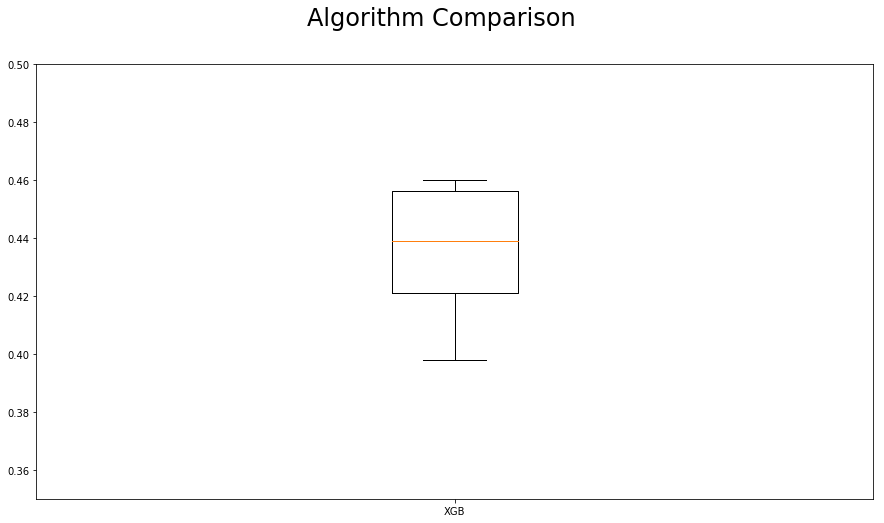

In [38]:
v_xgb = XGBClassifier(learning_rate=0.02, n_jobs=-1, objective='multi:softmax', random_state=seed)

models = []
models.append(('XGB', v_xgb))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, v_X_train, v_y_train, cv=kfold, scoring='f1_micro', n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Algorithm Comparison', fontsize=24)
ax = fig.add_subplot(1,1,1)
plt.boxplot(results)
plt.ylim([0.35,0.50])
ax.set_xticklabels(names)
plt.show()

In [39]:
# Test Performance

v_test_model = XGBClassifier(learning_rate=0.02, n_jobs=-1, objective='multi:softmax', random_state=seed)
v_test_model.fit(v_X_train, v_y_train)
v_y_pred = v_test_model.predict(v_X_test)
# F1
print("F1 score on multiclass unseen data: %.3f" % f1_score(v_y_test, v_y_pred, average='micro'))

F1 score on multiclass unseen data: 0.474


c:\users\eugen\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## first prediction

In [50]:
# bin_X_pred is the data to predict with the same features of train_feat
bin_X_pred = test_data[bin_feat]

In [51]:
bin_classifier = XGBClassifier(learning_rate=0.05, n_estimators= 450,
                           max_depth=5, min_child_weight=2,
                           colsample_bytree=0.75, subsample=0.85,
                           reg_alpha=0.8, reg_lambda=0.9,
                           n_jobs=-1, objective='binary:logistic', random_state=seed)

bin_classifier.fit(train_feat, bin_train_label)
# bin_y_pred is the binary prediction for the whole testset
bin_y_pred = bin_classifier.predict(bin_X_pred)

c:\users\eugen\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## second prediction

In [52]:
# v_X_pred is the data to predict with the same features of train_feat, a subset of bin_X_pred for which bin_y_pred = 1
v_X_pred = bin_X_pred
for i in range(0,len(bin_y_pred)):
    if(bin_y_pred[i] == 0):
        v_X_pred = v_X_pred.drop(i)
v_X_pred = v_X_pred[v_feat]

In [53]:
v_classifier = XGBClassifier(learning_rate=0.02, n_jobs=-1, objective='multi:softmax', random_state=seed)

v_classifier.fit(v_train_feat, v_train_label)
# v_y_pred is the multiclass prediction for the values of the testset for which it was predicted the label 1 in bin_y_pred
v_y_pred = v_classifier.predict(v_X_pred)

c:\users\eugen\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [24]:
# train_data, test_data are the original datasets (without binary feats)
# ((9567, 41), (3190, 40)) -> ((9567, 34), (3190, 40))
# label MULTICLASS

# X,Y are the splits of train_data between features and labels used to evaluate SelectKBest
# ((9567, 33), (9567,))
# label MULTICLASS

# train_feat, train_label are the splits of train_data between features and labels
# (9567, 29), (9567,)
# label MULTICLASS

# bin_train_label is the same of train_label but BINARY
# (9567,)
# label BINARY

# bin_X_train, bin_X_test, bin_X_val, bin_y_train, bin_y_test, bin_y_val are the splits of train_feat and bin_train_label
# (8617, 29), (950, 29), (0, 29), (8617,), (950,), (0,)
# label BINARY

# v_train_feat, v_train_label are subsets of train_feat and train_label for which bin_train_label is equal to 1
# (4189, 29), (4189,)
# label MULTICLASS

# v_X_train, v_X_test, v_X_val, v_y_train, v_y_test, v_y_valare the splits of v_train_feat and v_train_label
# (3769, 29), (420, 29), (0, 29), (3769,), (420,), (0,)
# label MULTICLASS

# bin_X_pred is the data to predict with the same features of train_feat
# (3190, 29)

# bin_y_pred is the binary prediction for the whole testset
# (3190,)
# label BINARY

# v_X_pred is the data to predict with the same features of train_feat, a subset of bin_X_pred for which bin_y_pred = 1
# (1239, 29)

# v_y_pred is the multiclass prediction for the values of the testset for which it was predicted the label 1 in bin_y_pred
# (1239,)
# label MULTICLASS

In [103]:
bin_y_pred.shape,pd.DataFrame({'wewe':v_y_pred}).describe()
bin_y_pred,v_y_pred

(array([1, 0, 1, ..., 0, 0, 0]), array([2, 2, 3, ..., 3, 3, 3], dtype=int64))

In [54]:
pred = []
ct = 0

for i in range(0,len(bin_y_pred)):
    if(bin_y_pred[i] == 1):
        pred.append(v_y_pred[ct])
        ct += 1
    else:
        pred.append(0)
for i in range(len(pred)):
    print(str(pred[i]) + " <- " + str(bin_y_pred[i]))

2 <- 1
2 <- 1
3 <- 1
2 <- 1
3 <- 1
2 <- 1
2 <- 1
0 <- 0
0 <- 0
3 <- 1
0 <- 0
0 <- 0
2 <- 1
0 <- 0
0 <- 0
2 <- 1
2 <- 1
2 <- 1
2 <- 1
0 <- 0
2 <- 1
0 <- 0
2 <- 1
0 <- 0
2 <- 1
2 <- 1
2 <- 1
2 <- 1
2 <- 1
0 <- 0
2 <- 1
0 <- 0
0 <- 0
2 <- 1
0 <- 0
0 <- 0
2 <- 1
0 <- 0
2 <- 1
2 <- 1
2 <- 1
0 <- 0
3 <- 1
3 <- 1
3 <- 1
3 <- 1
3 <- 1
0 <- 0
0 <- 0
0 <- 0
0 <- 0
2 <- 1
3 <- 1
3 <- 1
3 <- 1
3 <- 1
1 <- 1
3 <- 1
0 <- 0
2 <- 1
2 <- 1
0 <- 0
0 <- 0
2 <- 1
0 <- 0
0 <- 0
2 <- 1
3 <- 1
2 <- 1
0 <- 0
0 <- 0
3 <- 1
0 <- 0
2 <- 1
0 <- 0
0 <- 0
0 <- 0
0 <- 0
3 <- 1
2 <- 1
0 <- 0
2 <- 1
0 <- 0
0 <- 0
0 <- 0
0 <- 0
2 <- 1
2 <- 1
0 <- 0
2 <- 1
0 <- 0
3 <- 1
0 <- 0
0 <- 0
0 <- 0
0 <- 0
0 <- 0
0 <- 0
0 <- 0
0 <- 0
0 <- 0
0 <- 0
0 <- 0
2 <- 1
0 <- 0
0 <- 0
2 <- 1
0 <- 0
0 <- 0
2 <- 1
3 <- 1
3 <- 1
3 <- 1
0 <- 0
0 <- 0
0 <- 0
0 <- 0
0 <- 0
3 <- 1
0 <- 0
3 <- 1
0 <- 0
0 <- 0
2 <- 1
2 <- 1
0 <- 0
0 <- 0
0 <- 0
0 <- 0
2 <- 1
0 <- 0
0 <- 0
0 <- 0
0 <- 0
3 <- 1
3 <- 1
0 <- 0
0 <- 0
3 <- 1
0 <- 0
0 <- 0
2 <- 1
0 <- 0

3 <- 1
3 <- 1
0 <- 0
2 <- 1
3 <- 1
0 <- 0
0 <- 0
0 <- 0
3 <- 1
0 <- 0
3 <- 1
0 <- 0
0 <- 0
0 <- 0
0 <- 0
2 <- 1
3 <- 1
0 <- 0
2 <- 1
0 <- 0
1 <- 1
3 <- 1
0 <- 0
0 <- 0
3 <- 1
0 <- 0
0 <- 0
0 <- 0
0 <- 0
0 <- 0
3 <- 1
3 <- 1
3 <- 1
3 <- 1
0 <- 0
0 <- 0
0 <- 0
3 <- 1
0 <- 0
2 <- 1
0 <- 0
0 <- 0
2 <- 1
0 <- 0
0 <- 0
2 <- 1
0 <- 0
0 <- 0
2 <- 1
2 <- 1
0 <- 0
0 <- 0
0 <- 0
2 <- 1
3 <- 1
0 <- 0
3 <- 1
0 <- 0
0 <- 0
0 <- 0
0 <- 0
2 <- 1
3 <- 1
0 <- 0
3 <- 1
0 <- 0
0 <- 0
0 <- 0
2 <- 1
0 <- 0
0 <- 0
0 <- 0
0 <- 0
0 <- 0
2 <- 1
0 <- 0
2 <- 1
0 <- 0
2 <- 1
0 <- 0
0 <- 0
0 <- 0
2 <- 1
0 <- 0
0 <- 0
0 <- 0
0 <- 0
2 <- 1
0 <- 0
0 <- 0
0 <- 0
0 <- 0
0 <- 0
0 <- 0
2 <- 1
0 <- 0
0 <- 0
0 <- 0
2 <- 1
0 <- 0
0 <- 0
0 <- 0
0 <- 0
2 <- 1
0 <- 0
0 <- 0
3 <- 1
0 <- 0
0 <- 0
0 <- 0
0 <- 0
0 <- 0
2 <- 1
0 <- 0
0 <- 0
2 <- 1
3 <- 1
2 <- 1
0 <- 0
0 <- 0
3 <- 1
2 <- 1
0 <- 0
0 <- 0
3 <- 1
2 <- 1
0 <- 0
0 <- 0
0 <- 0
2 <- 1
0 <- 0
3 <- 1
0 <- 0
0 <- 0
2 <- 1
0 <- 0
0 <- 0
0 <- 0
2 <- 1
0 <- 0
3 <- 1
0 <- 0
0 <- 0

In [55]:
submit = test_data['ID']
submit = pd.DataFrame({'ID': submit})

pred = np.asarray(pred)
pred = pd.DataFrame({'Product': pred})

product = []
product = pred.Product
product.replace({ 
    int(0) : 'Non-Customer', 
    int(1) : 'V-Bag', 
    int(2) : 'V-Pet', 
    int(3) : 'V-Auto'},
    inplace=True)

submit = submit.join(product)
submit.to_csv('prediction.csv', index = False, encoding='utf-8')